In [1142]:
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline
import re
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.integrate import quad
from math import *
from IPython.display import Javascript

In [1143]:
class color:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [1144]:
#constants
g0 = 9.8

In [1145]:
#Define motor class
class Motor:
    def __init__(self, name):
            file_name = name + '.txt'
            words = []

            #read the text file and split by word
            with open(file_name, 'r') as f:
                for line in f:
                    for word in line.split():
                        words.append(word)

            #search word array for the keyword total get index of value 2 words later
            motorTotalWeightIndex = words.index("total") + 2

            #search word array for keyword propellant get index of value 2 words later
            motorPropWeightIndex = words.index("propellant") + 2

            mTWSTR = words[motorTotalWeightIndex]
            mPWSTR = words[motorPropWeightIndex]

            #extract the value as an int from the word entry
            motorTotalWeight = int(re.search(r'\d+', mTWSTR).group())
            motorPropellantWeight = int(re.search(r'\d+', mPWSTR).group())
            
            self.name = name
            self.wetMass = motorTotalWeight
            self.propMass = motorPropellantWeight
            self.dryMass = motorTotalWeight - motorPropellantWeight
            
            #search the data for the thrust cure, interp 1D and add 0 line to -time and after MECO
            lines = [] #Declare an empty list named "lines"
            i = 0
            with open (file_name, 'rt') as in_file:  #Open file lorem.txt for reading of text data.
                for line in in_file: #For each line of text store in a string variable named "line", and
                    dataPoint = map(float, re.findall(r'\d+', line))
                    dataPointint = fromiter(dataPoint, dtype=float)
                    i = i + 1
                    if (len(dataPointint) > 2) & (i>4):
                        dataPointTogetherTime = dataPointint[0] + 0.01*dataPointint[1]

                        dataPointTogetherThrust = dataPointint[2] + 0.01*dataPointint[3]

                        #print(dataPointint)


                        lines.append([dataPointTogetherTime, dataPointTogetherThrust])  #add that line to our list of lines.

            linescon = concatenate(lines, axis=0 )

            times = linescon[0:][::2]
            
            self.timepoints = times
            
            thrust = linescon[1:][::2]
            
            self.thrustpoints = thrust
            
            testtime = linspace(0,5,100)

            thrustInterp = interp1d(times,thrust, fill_value = (0,0), bounds_error=False)
            
            self.ThrustCurve = thrustInterp
            
            #Total Impulse Calc
            totalImpulse = quad(self.ThrustCurve, min(self.timepoints), max(self.timepoints))
            
            self.totalI = totalImpulse[0]
            
            self.ISP = self.totalI / (self.propMass * (10**-3) * 9.8) #Ns/N
            
    def printspecs(self): #function to print motor specs
        print('Motor:', color.BOLD , self , color.END)
        print('Wet Mass:', self.wetMass, 'g')
        print('Prop Mass:', self.propMass, 'g')
        print('Dry Mass:', self.dryMass, 'g \n')
        print('ISP:', round(self.ISP,2) ,'sec')
    def plotThrustCurve(self): #function to plot thrustcurve
        testtime = linspace(0,max(self.timepoints),100)
        plt.plot(self.timepoints,self.thrustpoints, '.', color='red', label = self.name + ' data points')
        plt.plot(testtime,self.ThrustCurve(testtime), label= self.name + ' Interp Thrust Curve')
        plt.xlabel('Time [sec]')
        plt.ylabel('Thrust [N]')
        plt.legend()
        plt.grid()

    def __str__(self):
            return self.name #return name when print is called

In [1146]:
#define the rocket class
class Rocket:
    def __init__(self, name, diameter, dryMass, CP, dryCG, Cd):
        self.name = name
        self.diameter = diameter
        self.CA = pi*(diameter/2)**2
        self.dryMass = dryMass
        self.CP = CP
        self.dryCG = dryCG
        self.Cd = Cd
        self.dryStabilityMargin = (self.dryCG - self.CP)/self.diameter
        
    def printspecs(self): #function to print motor specs
        print('Rocket:', color.BOLD , self , color.END)
        print('Diameter:', round(self.diameter,2), 'in')
        print('Cross-Sectional Area', round(self.CA,2), 'in2')
        print('Dry Mass:', round(self.dryMass,2), 'g')
        print('CP:', round(self.CP,2), 'in')
        print('Dry CG:', round(self.dryCG,2), 'in')
        print('Cd:', round(self.Cd,2))
        print('Dry Stability Margin:', round(self.dryStabilityMargin,2))
        

    def __str__(self):
            return self.name #return name when print is called

In [1147]:
#Define Motor Library
J420 = Motor('AeroTech_J420')
J315 = Motor('AeroTech_J315')
J275 = Motor('AeroTech_J275')
J460 = Motor('AeroTech_J460')
J800 = Motor('AeroTech_J800')
K185 = Motor('AeroTech_K185')
K535 = Motor('AeroTech_K535')

#Define Rocket Library
Subscale2k18prediction = Rocket('Endavour',3,4634.75,31.7,42.7,0.44)
#Subscale2k18prediction = Rocket('Endavour',3,rocketDryMass,CP,dryCG,0.44)
#FullScale2k17 = Rocket('')
Subscale2k17 = Rocket("She'll Be Right",3,3.99e3,8*12-74.5,8*12-63.8,0.44)
Fullscale2k17 = Rocket("Effective - 1",3,5.14e3,94.75-74.4,94.75-59.8,0.44)

/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [1148]:
#Running SBR with mass variation 10.1 lb plus/minus 0.05 so 10.05 lb or 10.15 lb - J420.wetMass
#SBR possible mass range, only have rough gross take of measurement
minSBRmass = 453.592*10.05 - J420.wetMass
maxSBRmass = 453.592*10.25 - J420.wetMass
print('Min SBR mass:' , minSBRmass)
print('Max SBR mass:' , maxSBRmass)

Min SBR mass: 3908.5996000000005
Max SBR mass: 3999.318


# Select Configuration

 ROCKET SELECTED: 
Rocket:  She'll Be Right 
Diameter: 3 in
Cross-Sectional Area 7.07 in2
Dry Mass: 3990.0 g
CP: 21.5 in
Dry CG: 32.2 in
Cd: 0.44
Dry Stability Margin: 3.57


 MOTOR SELECTED: 
Motor:  AeroTech_J420 
Wet Mass: 650 g
Prop Mass: 345 g
Dry Mass: 305 g 

ISP: 193.19 sec


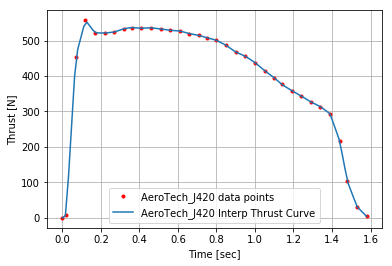

In [1149]:
#Select Rocket and Motor
rocketSelected = Subscale2k17#Subscale2k18prediction
motorSelected = J420

#Print
print(color.UNDERLINE, 'ROCKET SELECTED:', color.END)
rocketSelected.printspecs()

print('\n')

print(color.UNDERLINE, 'MOTOR SELECTED:', color.END)
motorSelected.printspecs()
motorSelected.plotThrustCurve()

# Simulation Script

In [1150]:
# Initial Conditions
m0 = (rocketSelected.dryMass + motorSelected.wetMass) * 1e-3 #g to kg
rocketAndMotorDryMass = (rocketSelected.dryMass + motorSelected.dryMass) * 1e-3 #g to kg

In [1151]:
#User Defined Initial Conditions
motorLength = 18 #in (This will vary with motor selection and not included in the thrust curve txt data....)

railLengthft = 8 #ft
railLength = railLengthft*0.3048

windSpeedmph = 5 #mph
windSpeed = windSpeedmph*0.44704 #m/s

In [1152]:
#Calculate rocket motor system CG, CP, and stability margin
CG0 = (rocketSelected.dryMass*rocketSelected.dryCG + (motorLength/2)*motorSelected.wetMass)/(rocketSelected.dryMass + motorSelected.wetMass)
CP = rocketSelected.CP
StaticStabilityMarginSelected = (CG0 - CP)/rocketSelected.diameter

print(color.BOLD, "SELECTED CONFIGURATION", color.END)
print("Gross Lift Off Weight:",round(m0,2),'kg')
print("CP:",round(CP,2),'in')
print("CG:",round(CG0,2),'in')
print("Static Stability Margin:", round(StaticStabilityMarginSelected,2))
thrustToWeightRatio = max(motorSelected.thrustpoints) / (m0*9.8)
print("Thrust To Weight Ratio:", round(thrustToWeightRatio,2))
print("System Dry Mass:", rocketAndMotorDryMass, 'kg')

 SELECTED CONFIGURATION 
Gross Lift Off Weight: 4.64 kg
CP: 21.5 in
CG: 28.95 in
Static Stability Margin: 2.48
Thrust To Weight Ratio: 12.25
System Dry Mass: 4.295 kg


In [1153]:
#Obtain Mass function from Thrust Curve, ISP, and g0 via Euler method
timestepSize = 1/1000
timesMass = arange(0,max(motorSelected.timepoints),timestepSize)
m = [m0]
i=0
while i < len(timesMass) - 1:
    massi = m[i] - (timesMass[i+1]-timesMass[i]) * float(motorSelected.ThrustCurve(timesMass[i])) / (g0 * motorSelected.ISP)
    m.append(massi)
    i = i+1

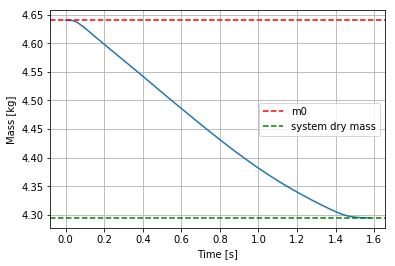

In [1154]:
#Plot Mass function
plt.plot(timesMass,m)
plt.axhline(m0,linestyle='--',color='red', label = 'm0')
plt.axhline(rocketAndMotorDryMass,linestyle='--',color='green', label = 'system dry mass')
plt.grid()
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Mass [kg]')
print('')

In [1155]:
#interpolate mass function
massInterp = interp1d(timesMass, m, fill_value = (m0,rocketAndMotorDryMass), bounds_error=False)

In [1156]:
#Define System Fucntions
def mass(t):
    return float(massInterp(t))

def weight(t):
    return mass(t)*g0

def thrust(t):
    return float(motorSelected.ThrustCurve(t)) *0.98 #thrust variation

def rho(y):
    return 1.225 #kg/m3 #return to add density as a function of alt

def ADASDeploymentPercentage(y,vy,ay):
    #insert ADAS Deployment Algorithm
    ADASDep = 0
    return ADASDep

def Cd(ADAS):
    #insert Cd(ADAS) function
    return rocketSelected.Cd #CD at 0

def Ca(ADAS):
    #insert Ca(ADAS) function
    CrossA = pi * (rocketSelected.diameter*0.0254/2)**2 #just the rocket
    return CrossA #CA at 0

In [1157]:
#Define System Internal Step Functions
def v(vy,vx):
    return sqrt(vy**2 + vx**2)

def a(ay,ax):
    return sqrt(ay**2 + ax**2)

def theta(y,vy,WS):
    if y <= railLength:
        return 0 #the rocket is still constained to the launch rail
    elif (y > railLength) and (y < (railLength + 10)): #assume tansition from rail to weather driven theta happens within 10m of rail exit
        return (90 - rad2deg(atan2(vy,WS)))*(y-railLength)/10
    else:
        return (90 - rad2deg(atan2(vy,WS))) #this represent weather cocking during flight
    
def Drag(y,vy,ay,v):
    #FD = -1/2 * CD * CA * v**2
    FD = -(1/2)*Cd(ADASDeploymentPercentage(y,vy,ay))*Ca(ADASDeploymentPercentage(y,vy,ay))*rho(y)*(v**2)
    return FD
    
def ay(t,y,vy,ay,v,WS):
    #ax = (T*cos(theta) - Wy - Dcos*(theta))  / m
    accely = ( (thrust(t) +  Drag(y,vy,ay,v)) * cos(deg2rad(theta(y,vy,WS))) - weight(t) ) / (mass(t))
    return accely
    
def ax(t,y,vy,ay,v,WS):
    #ay = (T*sin(theta) - Wy - Dsin*(theta))/m
    accelx = ( (thrust(t) +  Drag(y,vy,ay,v)) * sin(deg2rad(theta(y,vy,WS)))) / (mass(t))
    return accelx

In [1158]:
#Define Result Arrays and input intial values
resTime = [0] #sec
resX = [0] #m
resY = [0] #m
resM = [m0] #kg
resThrust = [thrust(resTime[0])] #N
resVx = [0] #m/s
resVy = [0] #m/s
resV = [v(resVx[0],resVy[0])] #m/s
resTheta = [theta(resY[0],resVy[0],windSpeed)] #m/s
resWeight = [resM[0] * g0] #N

resAy = [ay(resTime[0],resY[0],resVy[0],0,resV[0],windSpeed)] #set ay argument to 0 for intial - 1 value
resAx = [ax(resTime[0],resY[0],resVy[0],resAy[0],resV[0],windSpeed)]

resA = [a(resAy[0],resAx[0])]

resADAS = [ADASDeploymentPercentage(resY[0],resVy[0],resAy[0])]
resCA = [Ca(resADAS[0])]
resCD = [Cd(resADAS[0])]
resRho = [rho(resY[0])]
resFD = [Drag(resY[0],resVy[0],resAy[0],resV[0])]

In [1159]:
#Define Ascent Simulation
timestep = 0.01 #sec
i = 0

while i < 30/timestep: #Vyi > 0: #While moving upward,

    #====Time Step====
    #time step
    Ti = resTime[i]
    Tiplus1 = Ti + timestep
    resTime.append(Tiplus1)

    #====Lookup Values Step====
    #mass step
    Miplus1 = mass(Tiplus1)
    resM.append(Miplus1)

    #weight step
    Wiplus1 = weight(Tiplus1)
    resWeight.append(Wiplus1)

    #thrust step
    Tiplus1 = thrust(Tiplus1)
    resThrust.append(Tiplus1)

    #====Independent Variables Timestep====
    #x step
    Xi = resX[i]
    Vxi = resVx[i]
    Xiplus1 = Xi + Vxi * timestep
    resX.append(Xiplus1)

    #y step
    Yi = resY[i]
    Vyi = resVy[i]
    Yiplus1 = Yi + Vyi * timestep
    resY.append(Yiplus1)

    #vx step
    Axi = resAx[i]
    Vxiplus1 = Vxi + Axi * timestep
    resVx.append(Vxiplus1)

    #vy step
    Ayi = resAy[i]
    Vyiplus1 = Vyi + Ayi * timestep
    resVy.append(Vyiplus1)

    #====Dependent Values Calculate for Next Timestep====
    #velocity
    Viplus1 = v(Vyiplus1,Vxiplus1)
    resV.append(Viplus1)

    #Theta
    Thetaiplus1 = theta(Yiplus1,Vyiplus1,windSpeed)
    resTheta.append(Thetaiplus1)

    #ADAS
    ADASiplus1 = ADASDeploymentPercentage(Yi,Vyi,Ayi) #using previous step values
    resADAS.append(ADASiplus1)

    #CA
    CAiplus1 = Ca(ADASiplus1) #using previous step values
    resCA.append(CAiplus1)

    #CD
    CDiplus1 = Cd(ADASiplus1) #using previous step values
    resCD.append(CDiplus1)

    #rho
    rhoiplus1 = rho(Yiplus1)
    resRho.append(rhoiplus1)

    #Drag
    Vi = resV[i]
    Dragiplus1 = Drag(Yi,Vyi,Ayi,Vi) #using previous step values
    resFD.append(Dragiplus1)

    #ax
    Axiplus1 = ax(Ti,Yi,Vyi,Ayi,Vi,windSpeed) #using previous step values
    resAx.append(Axiplus1)

    #ay
    Ayiplus1 = ay(Ti,Yi,Vyi,Ayi,Vi,windSpeed) #using previous step values
    resAy.append(Ayiplus1)
    
    
    #Acceleration
    Aiplus1 = a(Axiplus1,Ayiplus1)
    resA.append(Aiplus1)

    i = i + 1

    if (Vyiplus1 < 0) and (Ti > max(motorSelected.timepoints)):
        break


In [1160]:
#get max Thrust to Weight ratio
TtoW = divide(resThrust,resWeight)
#plt.plot(resTime,TtoW)

# Simulation Results

In [1161]:
#Summary
print(color.BOLD, "SIMULATION RESULTS SUMMARY", color.END)

print(color.UNDERLINE, 'ROCKET SELECTED:', color.END)
rocketSelected.printspecs()

print('\n')

print(color.UNDERLINE, 'MOTOR SELECTED:', color.END)
motorSelected.printspecs()
#motorSelected.plotThrustCurve()

print(color.UNDERLINE, "INITIAL CONDITIONS", color.END)
print("Wind Speed:", windSpeedmph, 'mph')
print("Rail Length:", railLengthft, 'ft')

print('\n')

print(color.UNDERLINE, "STATIC VALUES", color.END)
print("Gross Lift Off Weight:",round(m0,2),'kg')
print("CP:",round(CP,2),'in')
print("CG:",round(CG0,2),'in')
print("Static Stability Margin:", round(StaticStabilityMarginSelected,2))
thrustToWeightRatio = max(motorSelected.thrustpoints) / (m0*9.8)
print("Thrust To Weight Ratio:", round(thrustToWeightRatio,2))
print("System Dry Mass:", rocketAndMotorDryMass, 'kg')

print('\n')

print(color.UNDERLINE, "DYNAMIC VALUES", color.END)
print("Apogee:", round(max(resY),2), 'm')
print("Max Absolute Velocity:", round(max(resV),2), 'm/s')
print("Max Absolute Acceleration:", round(max(resA),2), 'm/s2 or', round(max(resA)/9.8,2), "g's")
print("Max Thrust to Weight Ratio:", round(max(TtoW),2))


 SIMULATION RESULTS SUMMARY 
 ROCKET SELECTED: 
Rocket:  She'll Be Right 
Diameter: 3 in
Cross-Sectional Area 7.07 in2
Dry Mass: 3990.0 g
CP: 21.5 in
Dry CG: 32.2 in
Cd: 0.44
Dry Stability Margin: 3.57


 MOTOR SELECTED: 
Motor:  AeroTech_J420 
Wet Mass: 650 g
Prop Mass: 345 g
Dry Mass: 305 g 

ISP: 193.19 sec
 INITIAL CONDITIONS 
Wind Speed: 5 mph
Rail Length: 8 ft


 STATIC VALUES 
Gross Lift Off Weight: 4.64 kg
CP: 21.5 in
CG: 28.95 in
Static Stability Margin: 2.48
Thrust To Weight Ratio: 12.25
System Dry Mass: 4.295 kg


 DYNAMIC VALUES 
Apogee: 766.26 m
Max Absolute Velocity: 125.36 m/s
Max Absolute Acceleration: 108.38 m/s2 or 11.06 g's
Max Thrust to Weight Ratio: 12.06


In [1162]:
def find_nearest(array, value):
    array = asarray(array)
    idx = (abs(array - value)).argmin()
    return idx,array[idx]

In [1163]:
railExitSimindex = find_nearest(resY,railLength)[0]

Apogee: 766.26 m


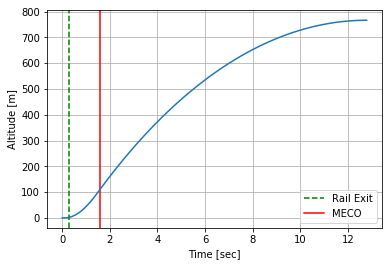

In [1176]:
MECO = max(motorSelected.timepoints)
railExitTime = resTime[railExitSimindex]
plt.axvline(x = railExitTime, color='green', linestyle ='--', label = 'Rail Exit')
plt.axvline(x = MECO, color='red', label = 'MECO')
plt.plot(resTime,resY)
plt.grid()
print("Apogee:", round(max(resY),2), 'm')
plt.xlabel('Time [sec]')
plt.ylabel('Altitude [m]')
plt.legend()
plt.savefig('Y_plot.png')

Exit Rail Velocity: 22.39 m/s
Exit Rail Velocity: 73.46 ft/s


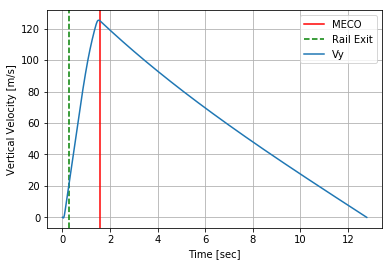

In [1177]:
plt.axvline(x = MECO, color='red', label = 'MECO')
plt.axvline(x = railExitTime, color='green', linestyle ='--', label='Rail Exit')
plt.plot(resTime,resVy, label = 'Vy')
plt.grid()
print("Exit Rail Velocity:", round(resVy[railExitSimindex],2),'m/s')
print("Exit Rail Velocity:", round(resVy[railExitSimindex] * 3.28084,2),'ft/s')
plt.xlabel('Time [sec]')
plt.ylabel('Vertical Velocity [m/s]')
plt.legend()
plt.savefig('Vy_plot.png')

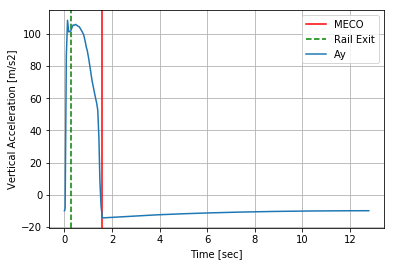

In [1178]:
plt.axvline(x = MECO, color='red', label = 'MECO')
plt.axvline(x = railExitTime, color='green', linestyle ='--', label='Rail Exit')
plt.plot(resTime,resAy, label = 'Ay')
plt.grid()
plt.xlabel('Time [sec]')
plt.ylabel('Vertical Acceleration [m/s2]')
plt.legend()
plt.savefig('Ay_plot.png')

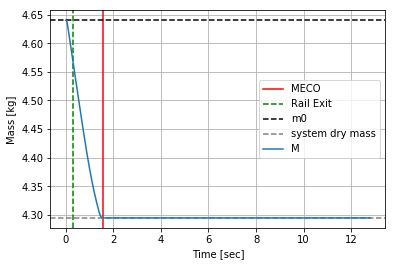

In [1179]:
plt.axvline(x = MECO, color='red', label = 'MECO')
plt.axvline(x = railExitTime, color='green', linestyle ='--', label='Rail Exit')

plt.axhline(m0,linestyle='--',color='black', label = 'm0')
plt.axhline(rocketAndMotorDryMass,linestyle='--',color='gray', label = 'system dry mass')

plt.plot(resTime,resM, label = 'M')
plt.grid()
plt.xlabel('Time [sec]')
plt.ylabel('Mass [kg]')
plt.legend()
plt.savefig('M_plot.png')

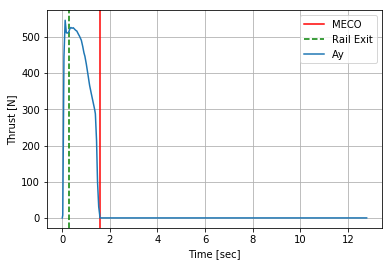

In [1180]:
plt.axvline(x = MECO, color='red', label = 'MECO')
plt.axvline(x = railExitTime, color='green', linestyle ='--', label='Rail Exit')
plt.plot(resTime,resThrust, label = 'Ay')
plt.grid()
plt.xlabel('Time [sec]')
plt.ylabel('Thrust [N]')
plt.legend()
plt.savefig('Thrust_plot.png')

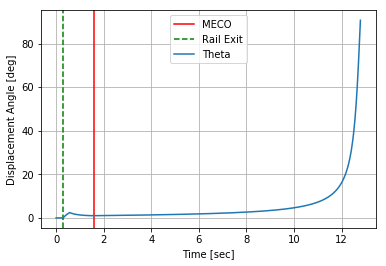

In [1181]:
plt.axvline(x = MECO, color='red', label = 'MECO')
plt.axvline(x = railExitTime, color='green', linestyle ='--', label='Rail Exit')
plt.plot(resTime,resTheta, label = 'Theta')
plt.grid()
plt.xlabel('Time [sec]')
plt.ylabel('Displacement Angle [deg]')
plt.legend()
plt.savefig('Theta_plot.png')

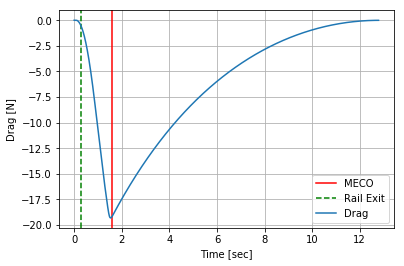

In [1182]:
plt.axvline(x = MECO, color='red', label = 'MECO')
plt.axvline(x = railExitTime, color='green', linestyle ='--', label='Rail Exit')
plt.plot(resTime,resFD, label = 'Drag')
plt.grid()
plt.xlabel('Time [sec]')
plt.ylabel('Drag [N]')
plt.legend()
plt.savefig('Drag_plot.png')

Max Thrust to Weight Ratio: 12.06


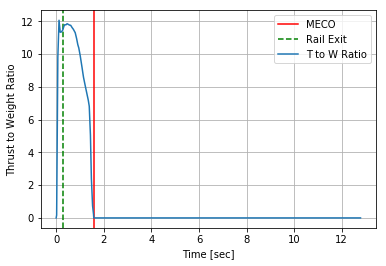

In [1183]:
plt.axvline(x = MECO, color='red', label = 'MECO')
plt.axvline(x = railExitTime, color='green', linestyle ='--', label='Rail Exit')
plt.plot(resTime,TtoW, label = 'T to W Ratio')
plt.grid()
plt.xlabel('Time [sec]')
plt.ylabel('Thrust to Weight Ratio')
plt.legend()

print("Max Thrust to Weight Ratio:", round(max(TtoW),2))

plt.savefig('TW_plot.png')

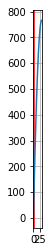

In [1172]:
plt.axvline(x = MECO, color='red')
plt.plot(resX,resY)
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')

Apogee: 766.26 m


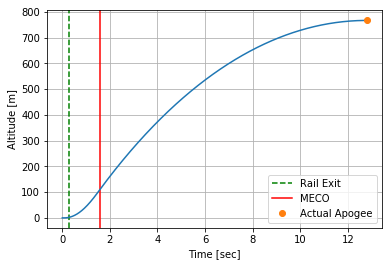

In [1184]:
MECO = max(motorSelected.timepoints)
railExitTime = resTime[railExitSimindex]
plt.axvline(x = railExitTime, color='green', linestyle ='--', label = 'Rail Exit')
plt.axvline(x = MECO, color='red', label = 'MECO')
plt.plot(resTime,resY)
plt.plot(max(resTime),767,'o',label = 'Actual Apogee')
plt.grid()
print("Apogee:", round(max(resY),2), 'm')
plt.xlabel('Time [sec]')
plt.ylabel('Altitude [m]')
plt.legend()

In [1061]:
#save nominal thrust to compare to other
#don't run again!
resYnomTh = resY
resTimenomTh = resTime

Apogee: 766.26 m


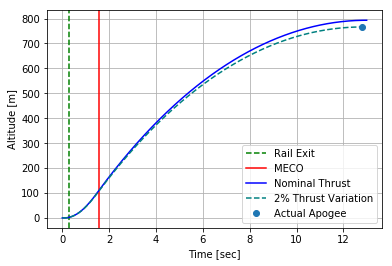

In [1185]:
MECO = max(motorSelected.timepoints)
railExitTime = resTime[railExitSimindex]
plt.axvline(x = railExitTime, color='green', linestyle ='--', label = 'Rail Exit')
plt.axvline(x = MECO, color='red', label = 'MECO')
plt.plot(resTimenomTh,resYnomTh, color = 'blue', label = 'Nominal Thrust')
plt.plot(resTime,resY, color = 'teal', linestyle = '--', label = '2% Thrust Variation')
plt.plot(max(resTime),767,'o',label = 'Actual Apogee')
plt.grid()
print("Apogee:", round(max(resY),2), 'm')
plt.xlabel('Time [sec]')
plt.ylabel('Altitude [m]')
plt.legend()
plt.savefig('Y_2percent_thrust_var_plot.png')